In [1]:
# Import libraries
import pandas as pd
import numpy as np
import dill as pickle

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import cross_validate

In [2]:
# Read VT data
data_df = pd.read_pickle("../data/interim/vtdata.pkl")
data_df = data_df.sample(frac=1, random_state=7).reset_index(drop=True)

vt_X = data_df.drop(columns="vt")
vt_y = data_df["vt"]

# ...and drop unwanted features to avoid spatial overfitting
vt_X = vt_X.drop(['x', 'y', 'plot_id'], axis=1)
_ = [print(x) for x in vt_X.columns]
vt_X.head()

B11_median_comp_Sent2
B12_median_comp_Sent2
B1_median_comp_Sent2
B2_median_comp_Sent2
B3_median_comp_Sent2
B4_median_comp_Sent2
B5_median_comp_Sent2
B6_median_comp_Sent2
B7_median_comp_Sent2
B8A_median_comp_Sent2
B8_median_comp_Sent2
B9_median_comp_Sent2
EVI_greenest_pixel_Sent2
EVI_median_comp_Sent2
GNDVI_greenest_pixel_Sent2
GNDVI_median_comp_Sent2
NDMI_greenest_pixel_Sent2
NDMI_median_comp_Sent2
NDVI_greenest_pixel_Sent2
NDVI_median_comp_Sent2
SAVI_greenest_pixel_Sent2
SAVI_median_comp_Sent2
B1_median_comp_Lands7
B2_median_comp_Lands7
B3_median_comp_Lands7
B4_median_comp_Lands7
B5_median_comp_Lands7
B6_median_comp_Lands7
B7_median_comp_Lands7
EVI_greenest_pixel_Lands7
EVI_median_comp_Lands7
GNDVI_greenest_pixel_Lands7
GNDVI_median_comp_Lands7
NDMI_greenest_pixel_Lands7
NDMI_median_comp_Lands7
NDVI_greenest_pixel_Lands7
NDVI_median_comp_Lands7
SAVI_greenest_pixel_Lands7
SAVI_median_comp_Lands7
ar50_artype
ar50_skogbon
ar50_treslag
ar50_veg
corine_lc_2012
geo_berggrunn
geo_grunnvann
g

,B11_median_comp_Sent2,B12_median_comp_Sent2,B1_median_comp_Sent2,B2_median_comp_Sent2,B3_median_comp_Sent2,B4_median_comp_Sent2,B5_median_comp_Sent2,B6_median_comp_Sent2,B7_median_comp_Sent2,B8A_median_comp_Sent2,...,tmax_6,tmax_8,tmax_9,tmin_5,tmin_9,topographic_wetness_index,total_insolation,valley_depth,vertical_distance_to_channel_network,visible_sky
0,0.21700,0.12775,0.04157,0.04070,0.05858,0.05915,0.10155,0.17385,0.19245,0.21790,...,20.5811,18.1146,12.9765,-4.5616,-1.6503,8.1780,1168.90918,121.9962,163.3139,94.1729
1,0.07680,0.03780,0.01560,0.01945,0.02982,0.01820,0.04752,0.12807,0.15217,0.16735,...,22.5382,20.2714,17.2824,0.7850,0.4542,6.8749,1211.49475,64.2473,25.2764,97.7724
2,0.20360,0.09220,0.06630,0.03990,0.06280,0.04020,0.12070,0.31450,0.35760,0.38720,...,17.6708,20.3218,14.5407,-3.4983,-2.3515,17.6024,993.73572,748.6170,0.0000,84.9623
3,0.22508,0.13655,0.02765,0.04070,0.06180,0.06697,0.11375,0.22545,0.25670,0.29110,...,21.9165,20.5618,15.8932,2.0480,4.8671,7.2655,1118.61890,103.4937,46.4838,94.7372
4,0.24625,0.13610,0.03075,0.04715,0.07305,0.07145,0.14155,0.25710,0.28145,0.31650,...,14.7530,16.7801,13.4581,-7.0645,-1.2334,7.3559,1399.06226,229.2504,62.1383,94.1043


In [4]:
# SUBSET SATELLITE DATA
import re

# Sentinel columns
sentinel_bands = [
    col for col in vt_X.columns if re.compile(".*B\d{1,2}.*Sent2.*").search(col)
]
sentinel_indices_med = [
    col for col in vt_X.columns if re.compile(
        ".*^(?!B\d{1,2}).*median_comp_Sent2.*"
    ).search(col)
]
sentinel_indices_mvc = [
    col for col in vt_X.columns if re.compile(
        ".*^(?!B\d{1,2}).*greenest_pixel_Sent2.*"
    ).search(col)
]
sentinel_indices = sentinel_indices_med + sentinel_indices_mvc

# Landsat columns
landsat_bands = [
    col for col in vt_X.columns if re.compile(".*B\d{1,2}.*Lands7.*").search(col)
]
landsat_indices_med = [
    col for col in vt_X.columns if re.compile(
        ".*^(?!B\d{1,2}).*median_comp_Lands7.*"
    ).search(col)
]
landsat_indices_mvc = [
    col for col in vt_X.columns if re.compile(
        ".*^(?!B\d{1,2}).*greenest_pixel_Lands7.*"
    ).search(col)
]
landsat_indices = landsat_indices_med + landsat_indices_mvc

In [11]:
# Load CV indices
with open('../data/misc/vtdata_5f_spatial_cv_indices.pkl', 'rb') as file:
    split_indices = pickle.load(file)

split_indices

[(array([    0,     1,     3, ..., 22168, 22169, 22170]),
  array([    2,     7,     9, ..., 22157, 22171, 22172])),
 (array([    0,     1,     2, ..., 22170, 22171, 22172]),
  array([   14,    58,    67, ..., 22158, 22166, 22167])),
 (array([    0,     1,     2, ..., 22168, 22171, 22172]),
  array([   11,    12,    23, ..., 22164, 22169, 22170])),
 (array([    0,     2,     4, ..., 22170, 22171, 22172]),
  array([    1,     3,     6, ..., 22163, 22165, 22168])),
 (array([    1,     2,     3, ..., 22170, 22171, 22172]),
  array([    0,     4,     5, ..., 22146, 22159, 22162]))]

In [12]:
scores = {
    'cohen_kappa': make_scorer(cohen_kappa_score),
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}
scores

{'cohen_kappa': make_scorer(cohen_kappa_score),
 'accuracy': 'accuracy',
 'f1_macro': 'f1_macro'}

In [20]:
def calculate_cv_mean_scores_and_std(cv_object):
    
    test_acc_mean = np.mean(cv_object['test_accuracy'])
    test_acc_std = np.std(cv_object['test_accuracy'])
    test_kappa_mean = np.mean(cv_object['test_cohen_kappa'])
    test_kappa_std = np.std(cv_object['test_cohen_kappa'])
    test_f1macro_mean = np.mean(cv_object['test_f1_macro'])
    test_f1macro_std = np.std(cv_object['test_f1_macro'])

    print(
        f"Acc: {round(test_acc_mean,3)} (±{round(test_acc_std,2)})\n"
        f"Kappa: {round(test_kappa_mean,3)} (±{round(test_kappa_std,2)})\n"
        f"F1-macro: {round(test_f1macro_mean,3)} (±{round(test_f1macro_std,2)})\n"
    )


In [21]:
# Sentinel bands

# 10-Fold Cross validation, all predictors
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_sentinel_bands = cross_validate(
    estimator=rf_default,
    X=vt_X[sentinel_bands],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_sentinel_bands)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s


Acc: 0.365 (±0.01)
Kappa: 0.309 (±0.01)
F1-macro: 0.2 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


In [22]:
# Sentinel SI - MED

# 10-Fold Cross validation, all predictors
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_sentinel_indices_med = cross_validate(
    estimator=rf_default,
    X=vt_X[sentinel_indices_med],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_sentinel_indices_med)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s


Acc: 0.309 (±0.0)
Kappa: 0.249 (±0.0)
F1-macro: 0.16 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.7s finished


In [23]:
# Sentinel SI - MVC

# 10-Fold Cross validation, all predictors
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_sentinel_indices_mvc = cross_validate(
    estimator=rf_default,
    X=vt_X[sentinel_indices_mvc],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_sentinel_indices_mvc)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s


Acc: 0.309 (±0.01)
Kappa: 0.25 (±0.01)
F1-macro: 0.158 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s finished


In [24]:
# Sentinel all

# 10-Fold Cross validation, all predictors
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_sentinel_all = cross_validate(
    estimator=rf_default,
    X=vt_X[sentinel_indices+sentinel_bands],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_sentinel_all)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.4s


Acc: 0.388 (±0.0)
Kappa: 0.334 (±0.0)
F1-macro: 0.21 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.9s finished


In [25]:
# Landsat bands
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_bands = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_bands],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_bands)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   1.5s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s


Acc: 0.295 (±0.0)
Kappa: 0.232 (±0.0)
F1-macro: 0.151 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.7s finished


In [26]:
# Landsat indices - MED
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_indices_med = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_indices_med],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_indices_med)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   1.7s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.7s


Acc: 0.253 (±0.01)
Kappa: 0.189 (±0.0)
F1-macro: 0.125 (±0.0)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s finished


In [27]:
# Landsat indices - MVC
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_indices_mvc = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_indices_mvc],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_indices_mvc)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.8s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s


Acc: 0.264 (±0.0)
Kappa: 0.2 (±0.0)
F1-macro: 0.129 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.0s finished


In [28]:
# Landsat both
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_all = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_indices + landsat_bands],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_all)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.4s


Acc: 0.343 (±0.0)
Kappa: 0.286 (±0.0)
F1-macro: 0.174 (±0.0)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.1s finished


In [29]:
# Both satellites, bands
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_and_sentinel_bands = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_bands + sentinel_bands],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_and_sentinel_bands)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.1s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s


Acc: 0.397 (±0.01)
Kappa: 0.344 (±0.01)
F1-macro: 0.218 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.0s finished


In [30]:
# Both satellites, SI - MED
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_and_sentinel_indices_med = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_indices_med + sentinel_indices_med],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_and_sentinel_indices_med)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   2.1s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s


Acc: 0.355 (±0.01)
Kappa: 0.298 (±0.01)
F1-macro: 0.178 (±0.0)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.9s finished


In [31]:
# Both satellites, SI - MVC
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_and_sentinel_indices_mvc = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_indices_mvc + sentinel_indices_mvc],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_and_sentinel_indices_mvc)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s


Acc: 0.344 (±0.0)
Kappa: 0.286 (±0.0)
F1-macro: 0.171 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.9s finished


In [32]:
# All satellite data
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_landsat_and_sentinel = cross_validate(
    estimator=rf_default,
    X=vt_X[landsat_indices + landsat_bands + sentinel_bands + sentinel_indices],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_landsat_and_sentinel)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.2s


Acc: 0.412 (±0.01)
Kappa: 0.36 (±0.01)
F1-macro: 0.219 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.5s finished


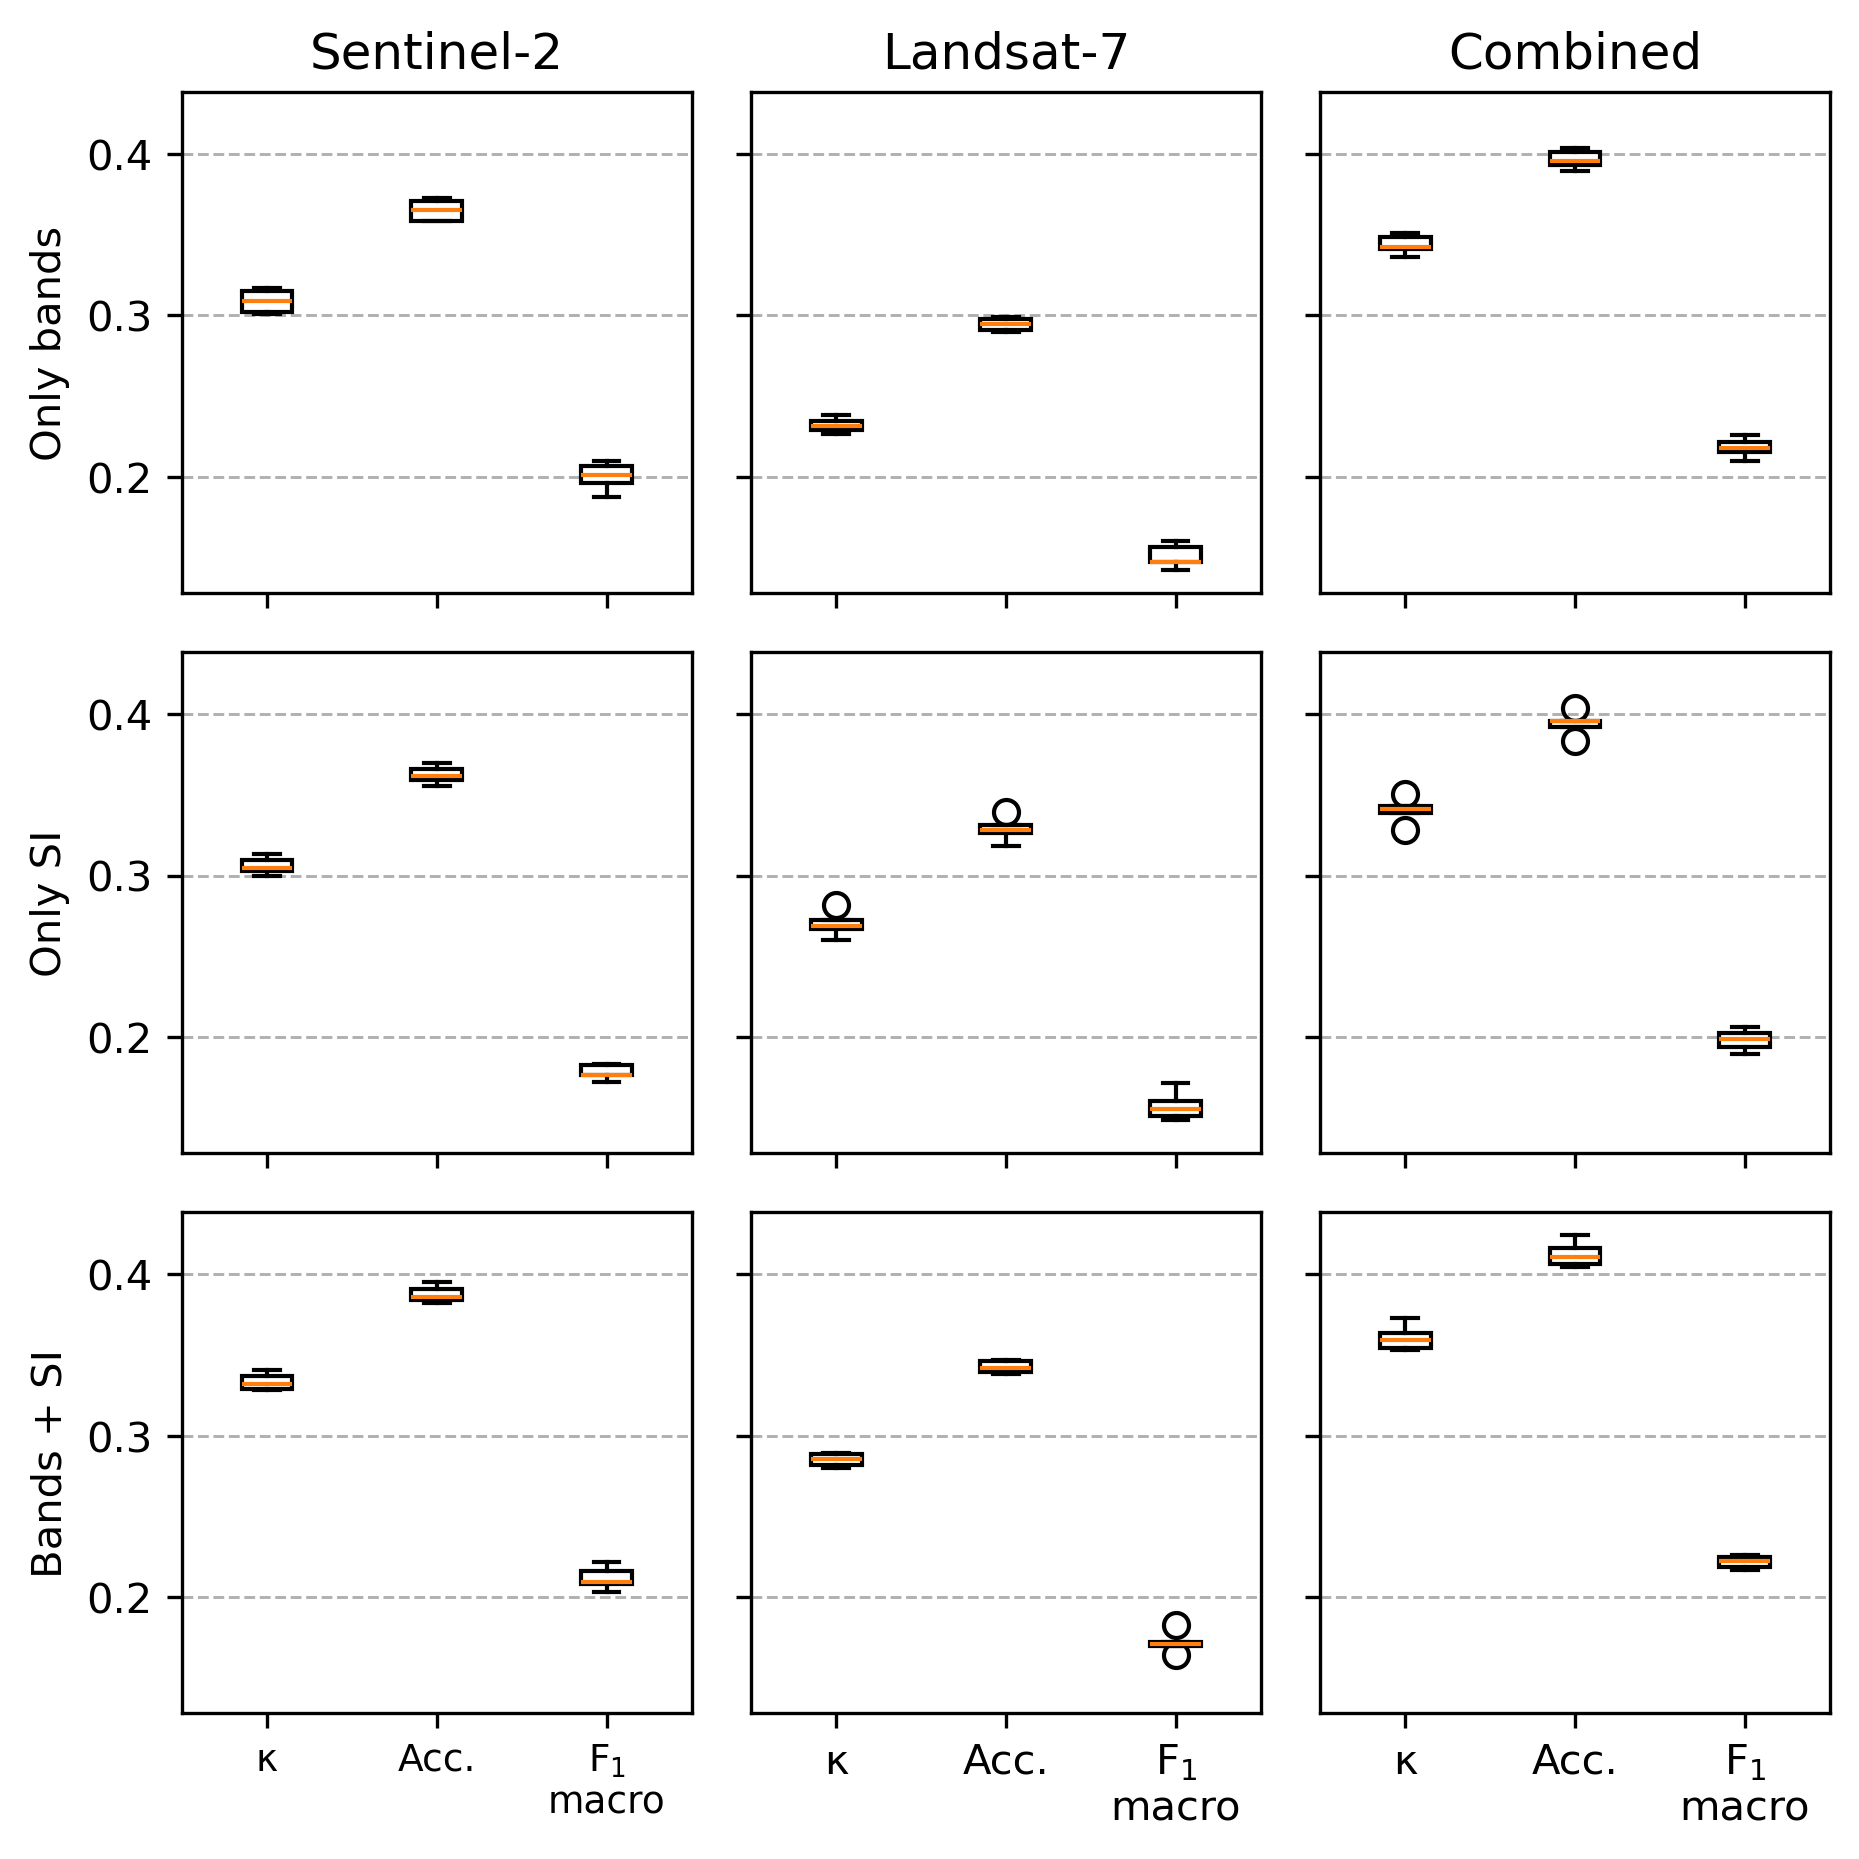

In [15]:
# Create plot
import matplotlib.pyplot as plt

test_score_columns = ["test_"+x for x in scores.keys()]

fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    sharex='all',
    sharey='all',
    figsize=(16/2.54, 16/2.54),
    dpi=300
)

boxprops = dict(
    linestyle='-',
    linewidth=1,
    color='black',
    facecolor='white'
)

for plot_idx, (pair_one, pair_two, pair_three) in enumerate(zip(
    [rf_cv_sentinel_bands, rf_cv_sentinel_indices, rf_cv_sentinel_both],
    [rf_cv_landsat_bands, rf_cv_landsat_indices, rf_cv_landsat_both],
    [rf_cv_landsat_and_sentinel_bands, rf_cv_landsat_and_sentinel_indices, rf_cv_landsat_and_sentinel],
)):
    
    axes[plot_idx, 0].boxplot(
        pd.DataFrame(pair_one)[test_score_columns],
        #positions=pos_nn,  # pos_list[idx_odd]-0.25, ## ODD INDICES
        #sym='',
        #widths=width,
        boxprops=boxprops,
        patch_artist = True,
    )

    axes[plot_idx, 1].boxplot(
        pd.DataFrame(pair_two)[test_score_columns],
        #positions=pos_nn,  # pos_list[idx_odd]-0.25, ## ODD INDICES
        #sym='',
        #widths=width,
        boxprops=boxprops,
        patch_artist = True,
    )

    axes[plot_idx, 2].boxplot(
        pd.DataFrame(pair_three)[test_score_columns],
        #positions=pos_nn,  # pos_list[idx_odd]-0.25, ## ODD INDICES
        #sym='',
        #widths=width,
        boxprops=boxprops,
        patch_artist = True,
    )

    if plot_idx == 0:
        axes[plot_idx, 0].set_title("Sentinel-2")
        axes[plot_idx, 1].set_title("Landsat-7")
        axes[plot_idx, 2].set_title("Combined")

        axes[plot_idx, 0].set_ylabel("Only bands")
    if plot_idx == 1:
        axes[plot_idx, 0].set_ylabel("Only SI")
    if plot_idx == 2:
        axes[plot_idx, 0].set_ylabel("Bands + SI")

        axes[plot_idx, 0].set_xticks([1, 2, 3])
        axes[plot_idx, 0].set_xticklabels(
            ["κ", "Acc.", "F$_{1}$\nmacro"],
            fontsize=9
        )

for ax in axes.flatten():
    ax.grid(
        axis='y',
        linestyle='--',
        linewidth=0.7,
        zorder=-1
    )

fig.tight_layout()

#fig.savefig("../results/plots/satellite_only_performance.png")

---
## Background dataset and satellite predictors

In [34]:
# Lead variable meta info from json
import json

with open("../data/dict/predictors.json", "r", encoding="utf-8") as json_file:
    var_dict = json.load(json_file)
var_dict

{'x': {'long_name': 'Easting',
  'dtype': 'continuous',
  'unit': 'm [UTM 32N WGS84]',
  'category': 'excluded'},
 'y': {'long_name': 'Northing',
  'dtype': 'continuous',
  'unit': 'm [UTM 32N WGS84]',
  'category': 'excluded'},
 'plot_id': {'long_name': 'Plot ID',
  'dtype': 'categorical',
  'unit': 'NA',
  'category': 'excluded'},
 'B1_median_comp_Sent2': {'long_name': 'Sent2 - B1 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance',
  'category': 'Satellite'},
 'B2_median_comp_Sent2': {'long_name': 'Sent2 - B2 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance',
  'category': 'Satellite'},
 'B3_median_comp_Sent2': {'long_name': 'Sent2 - B3 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance',
  'category': 'Satellite'},
 'B4_median_comp_Sent2': {'long_name': 'Sent2 - B4 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance',
  'category': 'Satellite'},
 'B5_median_comp_Sent2': {'long_name': 'Sent2 - B5 (MED)',
  'dtype': 'continuous',
 

In [51]:
# Retrieve other variable categories

satellite = landsat_indices + landsat_bands + sentinel_bands + sentinel_indices

baseline_land_cover = [
    key for key, item in var_dict.items() if item['category'] == "Baseline land cover"
]
climate = [
    key for key, item in var_dict.items() if item['category'] == "Climate"
]
geospatial = [
    key for key, item in var_dict.items() if item['category'] == "Geospatial"
]
geology = [
    key for key, item in var_dict.items() if item['category'] == "Geology"
]
geology.remove("geo_norge123")  # Artifact in data

In [17]:
def filter_strings(main_list, *other_lists) -> list:
    new_list = []

    for string in main_list:
        # Check if the string does not exactly match any string in other lists
        if all(string != item for sublist in other_lists for item in sublist):
            new_list.append(string)

    return new_list

In [52]:
# Baseline - climate
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_baselinelc_and_climate = cross_validate(
    estimator=rf_default,
    X=vt_X[baseline_land_cover + climate],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_baselinelc_and_climate)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.9s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s


Acc: 0.262 (±0.01)
Kappa: 0.209 (±0.01)
F1-macro: 0.209 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.2s finished


In [53]:
# Satellite - climate
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_satellite_and_climate = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + climate],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_satellite_and_climate)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.8s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s


Acc: 0.468 (±0.0)
Kappa: 0.424 (±0.0)
F1-macro: 0.329 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.3s finished


In [54]:
# Both LC - climate
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_all_lc_and_climate = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + baseline_land_cover + climate],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_all_lc_and_climate)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.7s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s


Acc: 0.482 (±0.0)
Kappa: 0.44 (±0.0)
F1-macro: 0.338 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.1s finished


In [55]:
# Baseline - geospatial
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_baselinelc_and_geospatial = cross_validate(
    estimator=rf_default,
    X=vt_X[baseline_land_cover + geospatial],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_baselinelc_and_geospatial)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.9s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s


Acc: 0.304 (±0.0)
Kappa: 0.249 (±0.0)
F1-macro: 0.21 (±0.0)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s finished


In [56]:
# Satellite - geospatial
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_satellite_and_geospatial = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + geospatial],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_satellite_and_geospatial)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   3.2s
[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time=   3.3s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.8s


Acc: 0.442 (±0.0)
Kappa: 0.393 (±0.0)
F1-macro: 0.257 (±0.0)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.8s finished


In [57]:
# Both - geospatial

rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_all_lc_and_geospatial = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + baseline_land_cover + geospatial],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_all_lc_and_geospatial)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.3s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.4s


Acc: 0.462 (±0.0)
Kappa: 0.416 (±0.0)
F1-macro: 0.274 (±0.0)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.4s finished


In [58]:
# Baseline - geology

rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_baselinelc_and_geology = cross_validate(
    estimator=rf_default,
    X=vt_X[baseline_land_cover + geology],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_baselinelc_and_geology)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.8s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s


Acc: 0.284 (±0.01)
Kappa: 0.225 (±0.01)
F1-macro: 0.189 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished


In [59]:
# Satellite - geology

rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_satellite_and_geology = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + geology],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_satellite_and_geology)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   2.8s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.1s


Acc: 0.414 (±0.01)
Kappa: 0.362 (±0.01)
F1-macro: 0.226 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.3s finished


In [60]:
# Both - geology

rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_all_lc_and_geology = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + baseline_land_cover + geology],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_all_lc_and_geology)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   3.0s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s


Acc: 0.443 (±0.0)
Kappa: 0.395 (±0.01)
F1-macro: 0.255 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.3s finished


In [61]:
# Baseline - all

rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_baselinelc_and_all = cross_validate(
    estimator=rf_default,
    X=vt_X[baseline_land_cover + climate + geospatial + geology],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_baselinelc_and_all)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   3.0s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.6s


Acc: 0.287 (±0.0)
Kappa: 0.235 (±0.0)
F1-macro: 0.227 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.7s finished


In [62]:
# Satellite - all

rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_satellite_and_all = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + climate + geospatial + geology],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_satellite_and_all)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   4.0s
[CV] END .................................................... total time=   4.1s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s


Acc: 0.472 (±0.0)
Kappa: 0.428 (±0.0)
F1-macro: 0.341 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.3s finished


In [64]:
# ALL ALL

rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_all_lc_and_all = cross_validate(
    estimator=rf_default,
    X=vt_X[satellite + baseline_land_cover + climate + geospatial + geology],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

calculate_cv_mean_scores_and_std(rf_cv_all_lc_and_all)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.8s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.3s


Acc: 0.485 (±0.01)
Kappa: 0.442 (±0.01)
F1-macro: 0.346 (±0.01)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.1s finished


In [19]:
# Only background vars
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

background_vars = filter_strings(
    vt_X.columns,
    landsat_indices,
    landsat_bands,
    sentinel_bands,
    sentinel_indices
)

rf_cv_only_background = cross_validate(
    estimator=rf_default,
    X=vt_X[background_vars],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

rf_cv_only_background

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.3s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.1s finished


{'fit_time': array([2.2359612 , 2.19450569, 2.141047  , 2.19405079, 2.22013211]),
 'score_time': array([0.07535315, 0.09609652, 0.06793475, 0.07760453, 0.06911612]),
 'estimator': [RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221)],
 'test_cohen_kappa': array([0.24825743, 0.23079806, 0.22752567, 0.23381036, 0.23253759]),
 'train_cohen_kappa': array([0.94593854, 0.94501433, 0.94913399, 0.94776994, 0.945477  ]),
 'test_accuracy': array([0.2994363 , 0.28365276, 0.28049605, 0.28642309, 0.28552097]),
 'train_accuracy': array([0.9494306 , 0.94858496, 0.95241854, 0.95112464, 0.94898247]),
 'test_f1_macro': array([0.23367854, 0.22858239, 0.23012238, 0.22314996, 0.21352775]),
 'train_f1_macro': arr

In [24]:
# Only background vars
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

background_no_landcover = filter_strings(
    background_vars,
    baseline_land_cover
)

rf_cv_background_no_lc = cross_validate(
    estimator=rf_default,
    X=vt_X[background_no_landcover],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

rf_cv_background_no_lc

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.5s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s finished


{'fit_time': array([2.2031641 , 2.45800185, 2.31414342, 2.20112753, 2.35328627]),
 'score_time': array([0.06903028, 0.07495713, 0.07046413, 0.06842089, 0.06910133]),
 'estimator': [RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221)],
 'test_cohen_kappa': array([0.21751498, 0.20865586, 0.20534848, 0.20759496, 0.20029498]),
 'train_cohen_kappa': array([0.9459449 , 0.94501474, 0.94913539, 0.94777451, 0.94546993]),
 'test_accuracy': array([0.27080045, 0.26290868, 0.25952649, 0.26206585, 0.25552548]),
 'train_accuracy': array([0.9494306 , 0.94858496, 0.95241854, 0.95112464, 0.94898247]),
 'test_f1_macro': array([0.21857227, 0.21661826, 0.20831162, 0.20028411, 0.19171984]),
 'train_f1_macro': arr

In [25]:
# Background + satellite
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10, random_state=221)

rf_cv_background_no_lc_sat = cross_validate(
    estimator=rf_default,
    X=vt_X[
        background_no_landcover +
        landsat_indices +
        landsat_bands +
        sentinel_bands +
        sentinel_indices
    ],
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

rf_cv_background_no_lc_sat

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.2s
[CV] END .................................................... total time=   3.2s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.0s finished


{'fit_time': array([3.07586312, 3.042413  , 3.07401705, 2.82046437, 3.09088945]),
 'score_time': array([0.07173324, 0.07513905, 0.0831039 , 0.07210803, 0.07105422]),
 'estimator': [RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221),
  RandomForestClassifier(n_jobs=10, oob_score=True, random_state=221)],
 'test_cohen_kappa': array([0.42950438, 0.42568168, 0.42537766, 0.43404751, 0.42609165]),
 'train_cohen_kappa': array([1.        , 0.99993974, 1.        , 0.99993977, 0.99993977]),
 'test_accuracy': array([0.47305524, 0.4692221 , 0.46967306, 0.47767253, 0.47045557]),
 'train_accuracy': array([1.        , 0.99994362, 1.        , 0.99994363, 0.99994363]),
 'test_f1_macro': array([0.34851809, 0.32859786, 0.32748331, 0.33801154, 0.31519343]),
 'train_f1_macro': arr

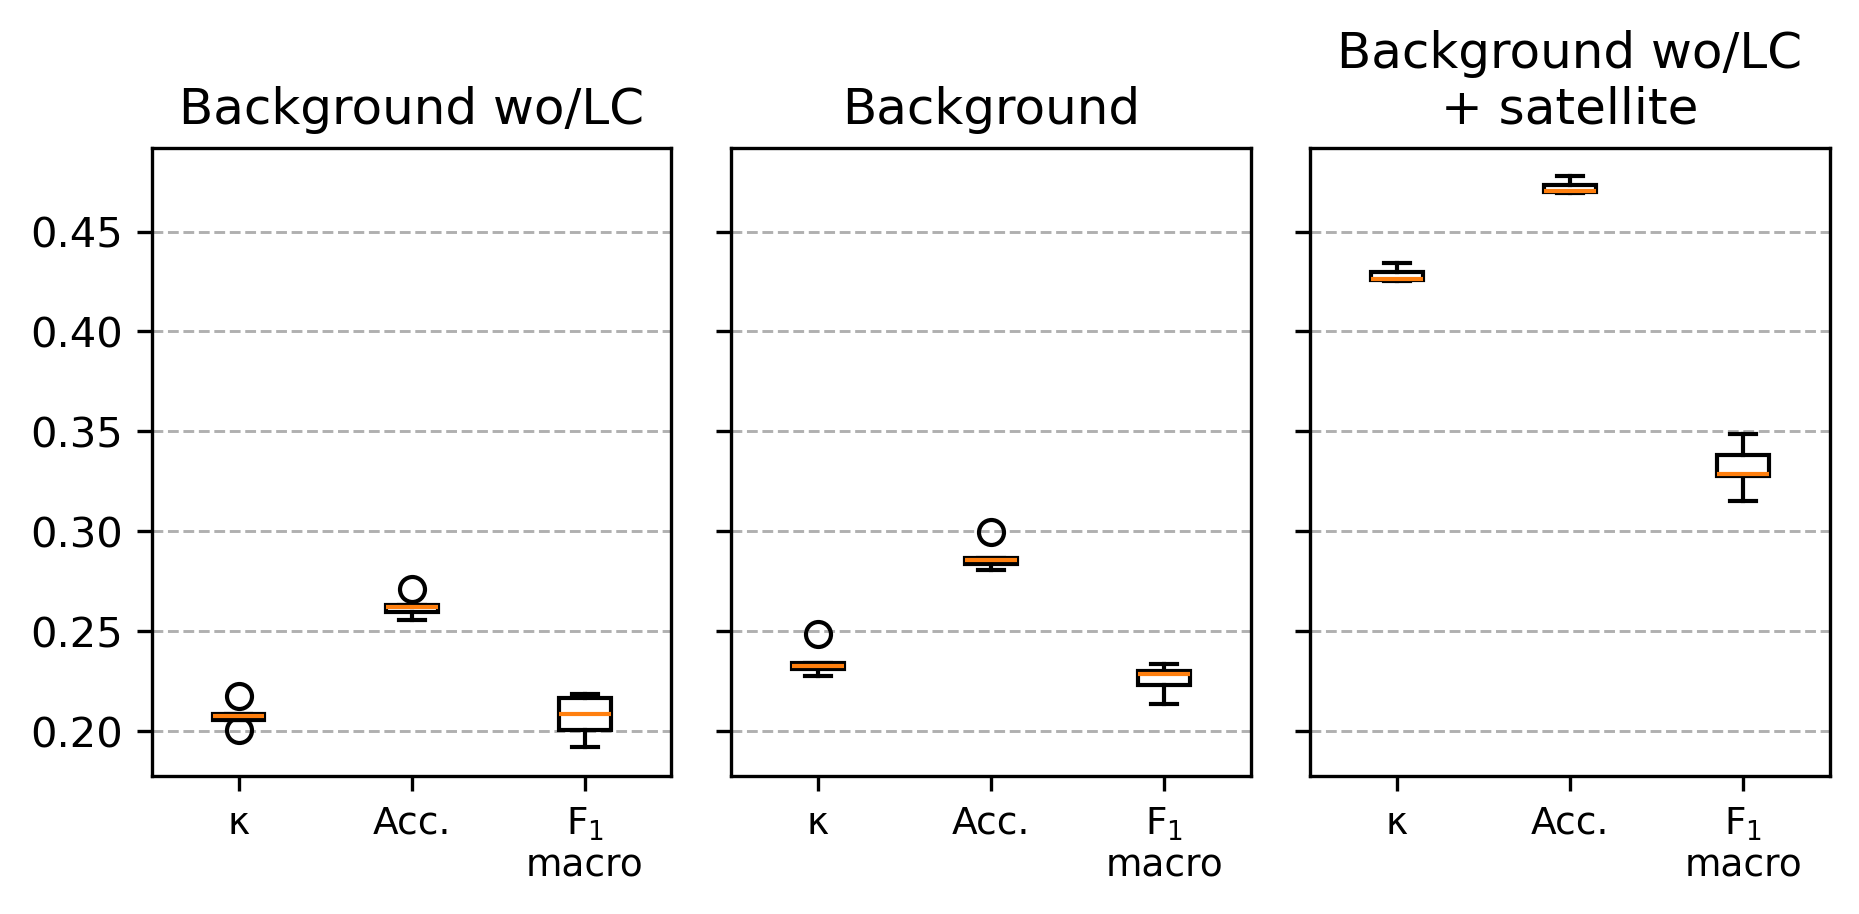

In [36]:
# PLOT
# Create plot
import matplotlib.pyplot as plt

test_score_columns = ["test_"+x for x in scores.keys()]

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    sharex='all',
    sharey='all',
    figsize=(16/2.54, 8/2.54),
    dpi=300
)

boxprops = dict(
    linestyle='-',
    linewidth=1,
    color='black',
    facecolor='white'
)

    
axes[0].boxplot(
    pd.DataFrame(rf_cv_background_no_lc)[test_score_columns],
    boxprops=boxprops,
    patch_artist = True,
)

axes[1].boxplot(
    pd.DataFrame(rf_cv_only_background)[test_score_columns],
    boxprops=boxprops,
    patch_artist = True,
)

axes[2].boxplot(
    pd.DataFrame(rf_cv_background_no_lc_sat)[test_score_columns],
    boxprops=boxprops,
    patch_artist = True,
)

axes[0].set_title("Background wo/LC")
axes[1].set_title("Background")
axes[2].set_title("Background wo/LC\n+ satellite")

for i in range(3):
    axes[i].set_xticks([1, 2, 3])
    axes[i].set_xticklabels(
        ["κ", "Acc.", "F$_{1}$\nmacro"],
        fontsize=9
    )

for ax in axes.flatten():
    ax.grid(
        axis='y',
        linestyle='--',
        linewidth=0.7,
        zorder=-1
    )

fig.tight_layout()
fig.savefig("../results/plots/bgvars_performance.png")

In [ ]:
# SAVE WORKSPACE
import dill                            #pip install dill --user
filename = 'globalsave.pkl'
dill.dump_session(filename)

# and to load the session again:
#dill.load_session(filename)